In [1]:
import numpy as np
import pandas as pd

import astropy.units as u
from astropy import coordinates, units as u, wcs
from astropy.io.votable import parse
from astropy.table import Table, Column, QTable
from astropy.io import fits
from astropy.visualization import simple_norm


from ipyaladin import Aladin
from ipywidgets import Layout, Box, widgets
import ipyaladin.aladin_widget as ipyal
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from astroquery.gaia import Gaia
from astroquery.vizier import Vizier

from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.nddata import CCDData
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon


import importlib 

from skimage import transform


%matplotlib notebook


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


# We want to create a DMD slit pattern for a certain FoV using GAIA data




In [2]:
# import functions to do stuff
import setup_obs_functions as sof

In [3]:
# test coordinates are from a SAMI image I've been using

RA = '06:08:8.455'                                                         
DEC = '24:20:55.14'
coords = SkyCoord(RA,DEC,unit=(u.hourangle,u.degree), frame='icrs')


print("coords=",coords)

coords= <SkyCoord (ICRS): (ra, dec) in deg
    (92.03522917, 24.34865)>


In [4]:
# General field of view we are looking for can be shown by aladin


### NOTICE HOW THE IMAGES ARE FLIPPED IN X/RA ###

fov = 4*u.arcmin
aladin = ipyal.Aladin(target=coords.to_string(), fov=fov.to(u.degree).to_value(), survey='DSS')

aladin

Aladin(fov=0.06666666666666667, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'over…

# Gaia query

We have a field of stars on which we wish to center slits made by the DMD.

We need Gaia astrometry for this, so select sets of stars to observe based on a Gaia query.
Link to info about returned tables: https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html

Passbands:\
Full G-band (330–1050 nm) 	\
GBP-band (330–680 nm) - bluer \
GRP-band (630–1050 nm) - redder 

Blue-Red color column is 'bp_rp', larger number means redder (faint in blue, bright in red)


In [5]:
importlib.reload(sof)
# GAIA query routine is in setup_obs_functions
table1 = sof.submit_gaia_query(coords)


# Pick some criteria for targets so that we aren't overwhelmed
pandacat = table1.to_pandas().drop(columns='index')
criteria=(pandacat['phot_bp_mean_mag'] > 10) & (pandacat['phot_rp_mean_mag'] < 15)

pandacat2 = pandacat[criteria].where(np.isnan(pandacat.parallax)==False).dropna(how='all').reset_index(drop=True)
table2 = QTable.from_pandas(pandacat2, index=True)


table2

HTTPError: OK

In [6]:
from astroquery.vizier import Vizier

Vizier.ROW_LIMIT = -1
viz_tables = Vizier.query_region(coordinates=coords, width = u.Quantity(4., u.arcmin),
                        height = u.Quantity(4., u.arcmin), catalog="gaia",)
#viz_tables = Vizier.query_region(coordinates="83.632944 -5.443575",height=height,width=width, 
#                                 catalog="2MASS")

print(viz_tables)
table1 = viz_tables[2]
#table1.sort("DEJ2000")

pandacat = table1.to_pandas()#.drop(columns='index')
pandacat = pandacat.rename(columns={"RA_ICRS": "ra", "e_RA_ICRS": "ra_error",
                                    "DE_ICRS":"dec", "e_DE_ICRS":"dec_error",
                                   "BPmag":"phot_bp_mean_mag", "RPmag":"phot_rp_mean_mag",
                                   "Plx": "parallax", "e_Plx":"parallax_error",
                                   "Source":"DESIGNATION"})
criteria=(pandacat['phot_bp_mean_mag'] > 10) & (pandacat['phot_rp_mean_mag'] < 15)
pandacat2 = pandacat[criteria].where(np.isnan(pandacat.parallax)==False).dropna(how='all').reset_index(drop=True)
table2 = QTable.from_pandas(pandacat2, index=True)

pandacat

TableList with 9 tables:
	'0:I/324/igsl3' with 18 column(s) and 261 row(s) 
	'1:I/337/gaia' with 14 column(s) and 222 row(s) 
	'2:I/345/gaia2' with 32 column(s) and 255 row(s) 
	'3:I/347/gaia2dis' with 9 column(s) and 212 row(s) 
	'4:I/350/gaiaedr3' with 39 column(s) and 260 row(s) 
	'5:I/352/gedr3dis' with 10 column(s) and 244 row(s) 
	'6:VI/137/gum_mw' with 17 column(s) and 299 row(s) 
	'7:VI/137/gum_gal' with 11 column(s) and 2 row(s) 
	'8:VI/145/attitude' with 18 column(s) and 3 row(s) 


,ra,ra_error,dec,dec_error,DESIGNATION,parallax,parallax_error,pmRA,e_pmRA,pmDE,...,phot_rp_mean_mag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum
0,92.063366,0.9510,24.334737,0.8349,3426275014669166336,-0.1893,0.8414,2.702,2.111,-1.249,...,19.3802,0.0777,1.2912,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,92.059580,0.6417,24.318587,0.5776,3426274976018035456,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,92.066264,0.8201,24.316703,0.7313,3426274941658341504,1.1294,0.9072,2.455,1.794,-1.200,...,19.2254,0.0529,2.2676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,92.063900,0.1465,24.327438,0.1347,3426275010372538752,0.2982,0.1385,1.060,0.285,0.612,...,17.2057,0.0092,1.1095,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92.059589,0.3767,24.318097,0.3575,3426274976012779008,0.5562,0.4031,-0.930,0.717,-0.348,...,18.2780,0.0485,1.3611,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,92.025810,0.0326,24.377271,0.0288,3426281989697771648,0.9675,0.0345,1.543,0.061,-0.042,...,14.3284,0.0019,1.0582,NaN,NaN,5322.2,0.7065,0.3558,1.1,0.879
251,92.028858,1.6539,24.372897,1.5234,3426281985404456192,NaN,NaN,NaN,NaN,NaN,...,18.8904,0.0710,2.1935,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252,92.064649,9.4590,24.380417,8.2768,3426282054124172160,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,92.065280,0.1367,24.379481,0.1257,3426282058417231104,0.3421,0.1498,0.176,0.273,-0.628,...,17.1888,0.0187,1.1213,NaN,NaN,NaN,NaN,NaN,NaN,NaN



# Now show the selected Gaia stars in the aladin viewer.

You can also change the center of our field of view and redo the query if you want.



In [7]:
import ipyaladin.aladin_widget as ipyal
importlib.reload(ipyal)

aladin = ipyal.Aladin(target=coords.to_string(), fov=0.06,survey='dss')


aladin

Aladin(fov=0.06, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'o…

In [8]:
#then overplot stars in our selected group

#need to create new gaia table or else it won't show for some reason
aladin_table = QTable(table2[['index','ra','ra_error','dec', 'dec_error', 'parallax', 'parallax_error']])

aladin.add_table(aladin_table)

# Find center coordinates of target field

Now that we have selected some stars in the general FoV from our initial coordinates, find the center coordinates of these selected stars to get a target center for the CCD. FoV is ~3.1$'$=186$''$ according to SAMI manual.

Generally, we want to know where we should point the telescope such that those pointing coordinates fall in the center of our CCD.

Right now, I am assuming that the telescope pointing will correspond to the center of our CCD.  This will be adjusted/fine-tuned when we run tests at SOAR.




In [9]:
RA_Center = (np.max(table2['ra'])-np.min(table2['ra'])) /2. + np.min(table2['ra'])


DEC_Center = (np.max(table2['dec'])-np.min(table2['dec'])) /2. + np.min(table2['dec'])

targ_center_coords = SkyCoord(RA_Center,DEC_Center,unit=u.deg,frame='icrs')
print(RA_Center, DEC_Center)

92.03352487209 24.353934677035


In [10]:
# From these center coordinates, we want to get the edges of the ~3' x 3' field of view, since not all of the 
# selected stars will be within that frame.

RA_max = RA_Center + 1.5/60.  # 1.5' is half of 3' (!)
RA_min = RA_Center - 1.5/60. 
if DEC_Center >= 0:
    DEC_max = DEC_Center + 1.5/60.  
    DEC_min = DEC_Center - 1.5/60.
else:
    DEC_min = -(-DEC_Center + 1.5/60.)  
    DEC_max = -(-DEC_Center - 1.5/60.)


print(RA_max,RA_min,DEC_max,DEC_min)

# Want to make sure selected stars are not within ~5 arcsec of the edges

edge_deg = (5.*u.arcsec).to(u.deg).value


finaltable = table2[(table2['ra']>RA_min+edge_deg) \
                            & (table2['ra']<RA_max-edge_deg) \
                            & (table2['dec']>DEC_min+edge_deg) & (table2['dec']<DEC_max-edge_deg) ]

finaldf = finaltable.to_pandas().drop(columns='index')
len(finaltable)
finaldf

92.05852487209 92.00852487208999 24.378934677034998 24.328934677035


,ra,ra_error,dec,dec_error,DESIGNATION,parallax,parallax_error,pmRA,e_pmRA,pmDE,...,phot_rp_mean_mag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum
0,92.018255,0.0277,24.330598,0.0249,3.426276e+18,0.8945,0.0306,1.491,0.053,-6.844,...,14.1452,0.0014,1.0449,NaN,NaN,5191.67,0.7640,0.3793,1.38,1.251
1,92.041362,0.0334,24.351779,0.0303,3.426276e+18,0.2972,0.0356,-0.520,0.063,-7.936,...,14.3674,0.0016,1.4799,NaN,NaN,4512.18,NaN,NaN,4.97,9.207
2,92.041540,0.0783,24.350118,0.0707,3.426276e+18,1.2908,0.0872,-0.487,0.146,-9.876,...,13.6541,0.0032,1.3132,NaN,NaN,4881.16,NaN,NaN,1.33,0.900
3,92.043725,0.0244,24.353994,0.0218,3.426276e+18,0.4434,0.0255,0.682,0.046,-3.245,...,13.4870,0.0021,0.6710,NaN,NaN,6426.80,0.5480,0.2280,2.57,10.188
4,92.022504,0.0204,24.362833,0.0181,3.426276e+18,0.2861,0.0224,-0.424,0.040,-2.382,...,13.0238,0.0025,0.4606,NaN,NaN,7893.67,NaN,NaN,3.54,43.811
5,92.013527,0.0229,24.350910,0.0204,3.426276e+18,0.1597,0.0253,0.072,0.043,-0.626,...,13.1843,0.0026,0.2306,NaN,NaN,9235.00,NaN,NaN,NaN,NaN
6,92.030885,0.1641,24.365329,0.1505,3.426276e+18,3.5513,0.1795,-2.747,0.308,-1.035,...,14.1319,0.0024,1.6591,NaN,NaN,4146.96,0.1890,0.0990,0.57,0.088
7,92.023776,0.1003,24.371611,0.0895,3.426276e+18,0.2122,0.1116,0.175,0.185,-1.800,...,13.5245,0.0015,1.4032,NaN,NaN,4519.31,0.4028,0.1918,NaN,NaN
8,92.050200,0.0408,24.357410,0.0368,3.426282e+18,1.1278,0.0427,2.856,0.078,-3.185,...,14.8740,0.0063,1.2211,NaN,NaN,4885.50,0.4933,0.2513,0.88,0.396
9,92.047229,0.0394,24.356098,0.0356,3.426282e+18,0.2032,0.0416,0.508,0.078,-1.970,...,14.9516,0.0034,0.8524,NaN,NaN,5543.66,NaN,NaN,NaN,NaN


In [11]:
# create a new WCS, but use the DMD scalings/rotations

DMD_Scale = (3.095*60)/1080
crmirror1 = 540  # center x of 1080x1080 DMD array
# really the array is 2048x1080 but we'll restrict it to mirrors within the FoV)
crmirror2 = 540 # center y of 1080x1080 DMD array

dmd_wcs = sof.create_wcs(pixscale1=DMD_Scale,pixscale2=DMD_Scale, pos_angle=0., naxis1=1080, naxis2=1080,
                     crval1=RA_Center, crval2=DEC_Center, crpix1=crmirror1, crpix2=crmirror2)


print(RA_Center, DEC_Center)
dmd_wcs

92.03352487209 24.353934677035


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 92.03352487209  24.353934677035  
CRPIX : 540.0  540.0  
CD1_1 CD1_2  : -4.7762345679012e-05  0.0  
CD2_1 CD2_2  : -0.0  4.77623456790123e-05  
NAXIS : 1080  1080

In [12]:
# We can now convert the sky coordinates RA and DEC to pixel coordinates using the WCS

pixcoords = np.asarray([skycoord_to_pixel(wcs=dmd_wcs,
                                    coords= SkyCoord(finaldf.loc[i,"ra"],
                                    finaldf.loc[i,"dec"], unit="deg")) for i in finaldf.index])

finaldf["x"] = pixcoords[:,0]
finaldf["y"] = pixcoords[:,1]

finaldf

,ra,ra_error,dec,dec_error,DESIGNATION,parallax,parallax_error,pmRA,e_pmRA,pmDE,...,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum,x,y
0,92.018255,0.0277,24.330598,0.0249,3.426276e+18,0.8945,0.0306,1.491,0.053,-6.844,...,1.0449,NaN,NaN,5191.67,0.7640,0.3793,1.38,1.251,830.311388,50.420097
1,92.041362,0.0334,24.351779,0.0303,3.426276e+18,0.2972,0.0356,-0.520,0.063,-7.936,...,1.4799,NaN,NaN,4512.18,NaN,NaN,4.97,9.207,389.511856,493.867550
2,92.041540,0.0783,24.350118,0.0707,3.426276e+18,1.2908,0.0872,-0.487,0.146,-9.876,...,1.3132,NaN,NaN,4881.16,NaN,NaN,1.33,0.900,386.121700,459.095856
3,92.043725,0.0244,24.353994,0.0218,3.426276e+18,0.4434,0.0255,0.682,0.046,-3.245,...,0.6710,NaN,NaN,6426.80,0.5480,0.2280,2.57,10.188,344.435441,540.259272
4,92.022504,0.0204,24.362833,0.0181,3.426276e+18,0.2861,0.0224,-0.424,0.040,-2.382,...,0.4606,NaN,NaN,7893.67,NaN,NaN,3.54,43.811,749.193519,725.316687
5,92.013527,0.0229,24.350910,0.0204,3.426276e+18,0.1597,0.0253,0.072,0.043,-0.626,...,0.2306,NaN,NaN,9235.00,NaN,NaN,NaN,NaN,920.442011,475.706055
6,92.030885,0.1641,24.365329,0.1505,3.426276e+18,3.5513,0.1795,-2.747,0.308,-1.035,...,1.6591,NaN,NaN,4146.96,0.1890,0.0990,0.57,0.088,589.341478,777.555619
7,92.023776,0.1003,24.371611,0.0895,3.426276e+18,0.2122,0.1116,0.175,0.185,-1.800,...,1.4032,NaN,NaN,4519.31,0.4028,0.1918,NaN,NaN,724.928818,909.093181
8,92.050200,0.0408,24.357410,0.0368,3.426282e+18,1.1278,0.0427,2.856,0.078,-3.185,...,1.2211,NaN,NaN,4885.50,0.4933,0.2513,0.88,0.396,220.956341,611.776552
9,92.047229,0.0394,24.356098,0.0356,3.426282e+18,0.2032,0.0416,0.508,0.078,-1.970,...,0.8524,NaN,NaN,5543.66,NaN,NaN,NaN,NaN,277.610042,584.309080


# Download an image from the HiPS server 

Image should have the same size/scalings/wcs as DMD so we can select stars and see what the pattern will look like.

In [13]:
from urllib.parse import urlencode

#get image with DMD params to see how we can get mirrors to match up with stars

hips = '2MASS/J'#'CDS/P/DSS2/red'
#result = hips2fits.query_with_wcs(
#   hips=hips,
#   wcs=w,
#   get_query_payload=False,
#   format='fits',
#   min_cut=0.5,
#   max_cut=99.5,
#   cmap=Colormap('viridis'),
#)
query_params = { 
             'hips': '2MASS/J',
#             'wcs': w, 
             'ra': RA_Center, 
             'dec': DEC_Center,
             'fov': (3.095 * u.arcmin).to(u.deg).value, 
             'projection': 'TAN',
             'width': 1080, 
             'height': 1080 
             }                                                                                               
url = f'http://alasky.u-strasbg.fr/hips-image-services/hips2fits?{urlencode(query_params)}' 
print(url)
hdul = fits.open(url)
hdul.info()
header = hdul[0].header
image = hdul[0].data

#hdul[0].data = np.fliplr(hdul[0].data)
#to save
filename  = "Strasbourg_DMDscale_"+str(np.round(RA_Center,13))+"_"+str(np.round(DEC_Center,13))+".fits"
hdul.writeto(filename,overwrite=True)
print(filename)
#print(header)
print('scale of DSS image: ',header['CDELT2']*3600.,'\n')


http://alasky.u-strasbg.fr/hips-image-services/hips2fits?hips=2MASS%2FJ&ra=92.03352487209&dec=24.353934677035&fov=0.051583333333333335&projection=TAN&width=1080&height=1080
Filename: /Users/danakoeppe/.astropy/cache/download/url/009fddf57e0682e8a3b070c984d248b8/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   (1080, 1080)   float32   
Strasbourg_DMDscale_92.03352487209_24.353934677035.fits
scale of DSS image:  0.1719444560583132 



# Pick out slits interactively



<IPython.core.display.Javascript object>


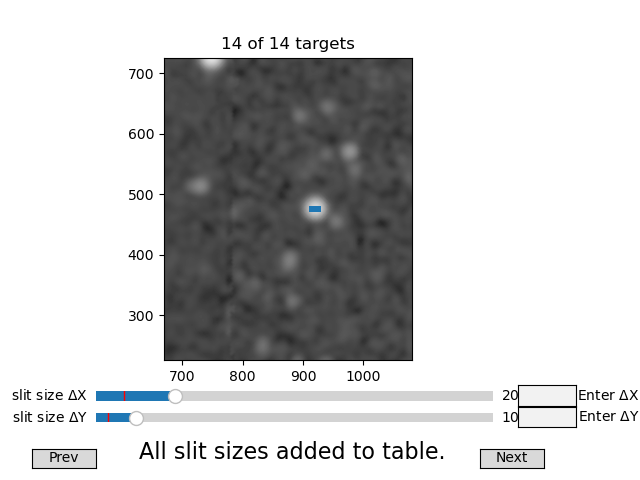

In [14]:

importlib.reload(sof)

# testing slit iterator 


fig1, ax1 = plt.subplots()
fig1.figsize=(8,8)

hipsnorm = simple_norm(data=image, stretch='log')

im1 = ax1.imshow(image, origin='lower',cmap='gray',norm=hipsnorm,)#extent=[-512, 512, -512, 512])


SlIter = sof.JupyterSlitSizeIterator(df=finaldf, fig=fig1, ax=ax1, imshape=image.shape)




In [15]:
# can also set the slit size manually instead of using the slider

SlIter.x_slider.set_val(20)
SlIter.y_slider.set_val(10)

In [16]:
SlIter.df

,ra,ra_error,dec,dec_error,DESIGNATION,parallax,parallax_error,pmRA,e_pmRA,pmDE,...,e_RV,Teff,AG,E_BP-RP_,Rad,Lum,x,y,dx,dy
0,92.050200,0.0408,24.357410,0.0368,3.426282e+18,1.1278,0.0427,2.856,0.078,-3.185,...,NaN,4885.50,0.4933,0.2513,0.88,0.396,220.956341,611.776552,86,3
1,92.047229,0.0394,24.356098,0.0356,3.426282e+18,0.2032,0.0416,0.508,0.078,-1.970,...,NaN,5543.66,NaN,NaN,NaN,NaN,277.610042,584.309080,56,3
2,92.043725,0.0244,24.353994,0.0218,3.426276e+18,0.4434,0.0255,0.682,0.046,-3.245,...,NaN,6426.80,0.5480,0.2280,2.57,10.188,344.435441,540.259272,59,3
3,92.041540,0.0783,24.350118,0.0707,3.426276e+18,1.2908,0.0872,-0.487,0.146,-9.876,...,NaN,4881.16,NaN,NaN,1.33,0.900,386.121700,459.095856,64,3
4,92.041362,0.0334,24.351779,0.0303,3.426276e+18,0.2972,0.0356,-0.520,0.063,-7.936,...,NaN,4512.18,NaN,NaN,4.97,9.207,389.511856,493.867550,63,3
5,92.041283,0.2605,24.360133,0.2472,3.426282e+18,-0.2532,0.3066,0.639,0.525,0.191,...,NaN,5050.11,NaN,NaN,NaN,NaN,391.033659,668.770988,58,3
6,92.035511,0.0413,24.373138,0.0376,3.426282e+18,0.3276,0.0448,0.481,0.077,-2.304,...,NaN,5805.57,NaN,NaN,NaN,NaN,501.115726,941.063051,61,3
7,92.030885,0.1641,24.365329,0.1505,3.426276e+18,3.5513,0.1795,-2.747,0.308,-1.035,...,NaN,4146.96,0.1890,0.0990,0.57,0.088,589.341478,777.555619,50,3
8,92.025810,0.0326,24.377271,0.0288,3.426282e+18,0.9675,0.0345,1.543,0.061,-0.042,...,NaN,5322.20,0.7065,0.3558,1.10,0.879,686.133173,1027.599985,68,3
9,92.025493,0.0245,24.374722,0.0215,3.426282e+18,0.3319,0.0257,0.844,0.045,-1.443,...,NaN,4773.00,0.5260,0.2540,7.61,27.060,692.171754,974.220339,65,3


In [17]:
importlib.reload(sof)

DMDPattern, dmd_slits, good_index = \
                    sof.create_dmd_pattern_from_target_table(SlIter.df,wcs=dmd_wcs,
                                                    ra_center=RA_Center,dec_center=DEC_Center,
                                                    slit_xsize=SlIter.df.dx.values,slit_ysize=SlIter.df.dy.values)

accepting first target 0
skipping target 1
accepting target 2


skipping target 3
skipping target 4
skipping target 5
accepting target 6


accepting target 7


accepting target 8


skipping target 9
skipping target 10
accepting target 11


accepting target 12


accepting target 13




In [18]:
DMDPattern

,target,ra,dec,x,y,dx1,dy1,dx2,dy2
0,3.426282e+18,92.050200,24.357410,220.956341,611.776552,43.0,1.5,43.0,1.5
1,3.426276e+18,92.043725,24.353994,344.435441,540.259272,29.5,1.5,29.5,1.5
2,3.426282e+18,92.035511,24.373138,501.115726,941.063051,30.5,1.5,30.5,1.5
3,3.426276e+18,92.030885,24.365329,589.341478,777.555619,25.0,1.5,25.0,1.5
4,3.426282e+18,92.025810,24.377271,686.133173,1027.599985,34.0,1.5,34.0,1.5
5,3.426276e+18,92.022504,24.362833,749.193519,725.316687,30.5,1.5,30.5,1.5
6,3.426276e+18,92.018255,24.330598,830.311388,50.420097,35.0,1.5,35.0,1.5
7,3.426276e+18,92.013527,24.350910,920.442011,475.706055,36.0,1.5,36.0,1.5
